In [1]:
import torch

自动微分

In [21]:
x=torch.arange(4.0,requires_grad=True)
print(x)
x.grad

tensor([0., 1., 2., 3.], requires_grad=True)


In [16]:
y=2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

In [17]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [27]:
x.grad.zero_()
y=x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [33]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y=x*x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [38]:
x.grad.zero_()
y=x*x
u=y.detach()
z=u*x
z.sum().backward()
x.grad

tensor([0., 1., 4., 9.])

In [39]:
x.grad.zero_()
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [59]:
def f(a):
    b=a*2
    while b.norm()<1000:
        b=b*2
    if b.sum()>0:
        c=b
    else:
        c=100*b
    return c

a=torch.randn(size=(),requires_grad=True)
d=f(a)
d.backward()
a.grad==d/a

tensor(True)

线性回归

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import torch

In [63]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [64]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()


In [70]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.08092 sec'

In [82]:
timer.start()
d = a + b
f'{timer.stop():.8f} sec'

'0.00100088 sec'

线性回归实现


In [3]:
%matplotlib inline
import random
import torch

In [4]:
def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


In [33]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)


In [9]:
print('features:', features[0],'\nlabel:', labels[0])


features: tensor([-0.3069, -0.4951]) 
label: tensor([5.2741])


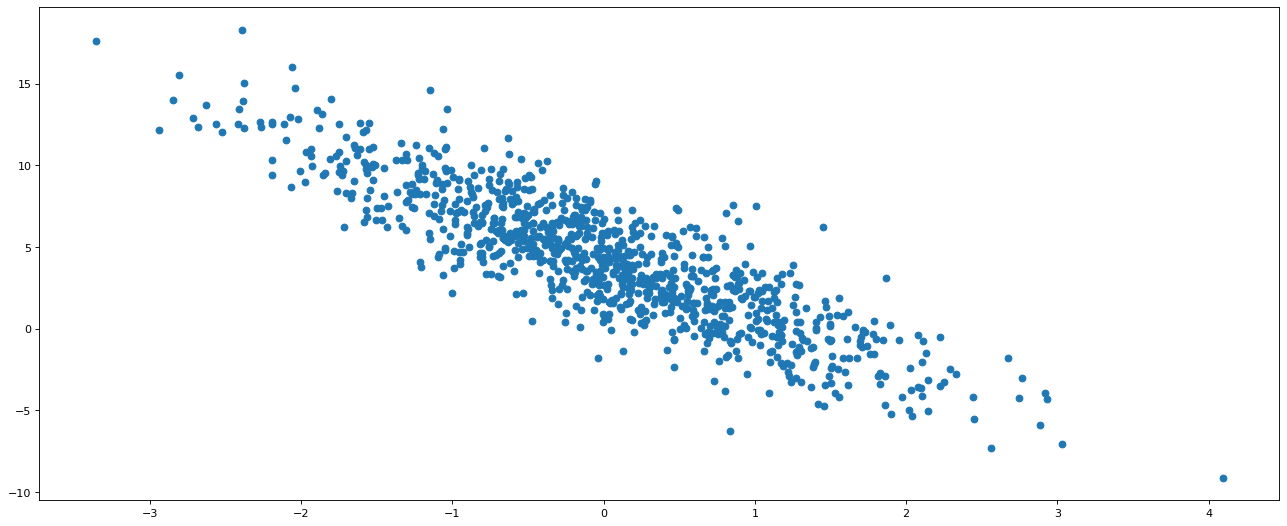

In [12]:
plt.figure(figsize=(20,8),dpi=80)
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy())

In [32]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [34]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.7567,  0.3593],
        [-0.0126,  2.4050],
        [ 2.1412,  0.7890],
        [-0.4965,  0.5478],
        [ 2.0338, -2.1480],
        [ 2.1730,  1.0185],
        [ 1.0430, -0.0721],
        [ 0.6900, -0.1905],
        [ 0.1100,  0.0808],
        [ 0.8355, -1.4072]]) 
 tensor([[ 4.5031],
        [-4.0184],
        [ 5.8040],
        [ 1.3548],
        [15.5736],
        [ 5.0808],
        [ 6.5130],
        [ 6.2196],
        [ 4.1591],
        [10.6605]])


In [35]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


In [36]:
def linreg(X, w, b): #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [17]:
def squared_loss(y_hat, y): #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [31]:
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [29]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [37]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        # print(l)
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.033163
epoch 2, loss 0.000111
epoch 3, loss 0.000050


In [28]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0008, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)


线性回归的简洁实现

In [5]:
import numpy as np
from torch.utils import data


In [6]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features,labels=synthetic_data(true_w,true_b,1000)

In [10]:
def load_array(data_arrays,batch_size,is_train=True):
    dataset=data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

In [12]:
batch_size=10
data_iter=load_array((features,labels),batch_size)
next(iter(data_iter))

[tensor([[ 1.2308,  0.4737],
         [ 0.9727,  0.3447],
         [-0.5008,  1.0313],
         [-0.5131, -0.9648],
         [-0.5625,  0.8303],
         [-0.9906,  0.2793],
         [ 0.5746,  2.6055],
         [ 1.5640,  0.4319],
         [-1.8685,  2.3845],
         [ 1.3845, -0.0088]]),
 tensor([[ 5.0537],
         [ 4.9656],
         [-0.3181],
         [ 6.4691],
         [ 0.2313],
         [ 1.2610],
         [-3.5157],
         [ 5.8551],
         [-7.6392],
         [ 6.9971]])]

In [13]:
from torch import nn

In [15]:
net=nn.Sequential(nn.Linear(2,1))

In [16]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [17]:
loss=nn.MSELoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.03)

In [18]:
num_epochs=3
for epoch in range(num_epochs):
    for X,y in data_iter:
        l=loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l=loss(net(features),labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000245
epoch 2, loss 0.000103
epoch 3, loss 0.000103


In [19]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0005, -0.0004])
b的估计误差： tensor([0.0003])


图像分类数据集

In [20]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

In [22]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
root="../data", train=False, transform=trans, download=True)


100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [23]:
len(mnist_train), len(mnist_test)


(60000, 10000)

In [24]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [25]:
def get_fashion_mnist_labels(labels): 
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [26]:
batch_size=256

train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)